# Εργασία 2 ΤΕΔεδομένων

Κωνσταντίνος Σκορδούλης 1115201600155

Ευστράτιος Ζωγραφάκης 1115201600049

In [1]:
import pandas as pd
import numpy as np

Load our dataframe

In [2]:
#file_name = './train_set_testing.tsv'
file_name = './train_set.tsv'



Train_df = pd.read_csv(file_name,sep='\t', usecols=['Id','Title','Content','Category'])

Train_df.index = Train_df['Id']

Train_df

,Id,Title,Content,Category
Id,,,,
1783,1783,Capriati out of Australian Open,Jennifer Capriati has become the third leadin...,sport
211,211,MG Rover China tie-up 'delayed',MG Rover's proposed tie-up with China's top c...,business
663,663,Oasis star fined for German brawl,Oasis singer Liam Gallagher has been fined 50...,entertainment
2024,2024,How to make a gigapixel picture,The largest digital panoramic photo in the wo...,tech
748,748,Fightstar take to the stage,Charlie Simpson took his new band Fightstar t...,entertainment
...,...,...,...,...
654,654,Sir Paul rocks Super Bowl crowds,Sir Paul McCartney wowed fans with a live min...,entertainment
2188,2188,Local net TV takes off in Austria,An Austrian village is testing technology tha...,tech
1283,1283,Plan to give elderly care control,Elderly and disabled people would choose how ...,politics


# Document-words

Create <b>bag of Words</b> (μόνο για το Content)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=1000,
stop_words='english')

counts = bow_vectorizer.fit_transform(Train_df.Content)
counts

<1780x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 119387 stored elements in Compressed Sparse Row format>

Transfrom count to tfidf --> <b>TFidf_Transformer()</b> ---> maybe TfidfVectorizer()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000,
stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(Train_df.Content)
tfidf

<1780x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 119387 stored elements in Compressed Sparse Row format>

# Document-embedings

In [9]:
#from gensim.models import Word2Vec

#Unfortunately word2vec is deprecated => use gensim.models.KeyedVectors.load_word2vec_format()

from gensim.models import KeyedVectors

In [10]:
#w2vec = Word2Vec.load_word2vec_format('./GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary=True)

w2vec = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary=True)

#w2vec

Get word_vectors from w2vec

In [11]:
word_vectors = w2vec.wv 

#word_vectors['hello']

#word_vectors.vocab

C:\Users\kostantinos\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [12]:
tfidf.toarray().shape

(1780, 1000)

Compute mean vector of each sentence 

In [13]:
l_list = []

words_tfidf = tfidf_vectorizer.get_feature_names()

for x in tfidf.toarray(): #for each vector/sentence in tfidf
    list1 = []
    for i,y in enumerate(x): #for each word 
        
        #if word doesn't exist in sentence or word doesn't exist in word2vec
        if( (y == 0) or ( words_tfidf[i] not in word_vectors) ):
            continue
        
        vector = w2vec[words_tfidf[i]] * y # y = how many times this word has appeared in our sentence
        
        #list1.append(w2vec[words_tfidf[i]])
        list1.append(w2vec[words_tfidf[i]])
    
    a = np.array(list1)
    avg_vec = a.mean(axis=0)
    l_list.append(avg_vec)

w2vec_arrays = np.array(l_list)  

In [14]:
#w2vec_arrays.shape
w2vec_arrays

array([[-0.0016965 ,  0.0370206 ,  0.04446064, ..., -0.02172366,
        -0.00531769, -0.04798512],
       [-0.01286254,  0.02725189, -0.00709004, ..., -0.01808704,
         0.06367368, -0.09046531],
       [ 0.05120172,  0.06465319,  0.02407611, ...,  0.00771431,
         0.04152538, -0.0726567 ],
       ...,
       [ 0.00245474,  0.02545905,  0.02299034, ..., -0.03607575,
         0.01020672, -0.0236659 ],
       [ 0.00460481,  0.06516643,  0.01405449, ..., -0.03593067,
         0.00605438,  0.04618721],
       [ 0.02411382,  0.04128243,  0.00510676, ..., -0.02786524,
         0.05177969, -0.02601534]], dtype=float32)

# K-MEANS

Για να μπορέσουμε να πετύχουμε cosine similarity, αποφασίσαμε να κάνουμε normalize τα δεδομένα μας
όπως συζητήθηκε εδώ https://eclass.uoa.gr/modules/forum/viewtopic.php?course=D424&topic=24308&forum=35727

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Normalizing input for KMeans

In [16]:
from sklearn import preprocessing

w2vec_norm = preprocessing.normalize(w2vec_arrays)
tfidf_norm = preprocessing.normalize(tfidf.toarray())
counts_norm = preprocessing.normalize(counts.toarray())



We will need to visualize our result. 

Counts(Bow) δεν μας δίνει χρησιμη πληροφρία, οπότε θα αχοληθούμε με tfidf και w2vec.

Αν λάβουμε υπόψιν τις συναρτήσεις PCA,SVD,ICA , θέλουμε 6 γραφήματα.

In [17]:
from sklearn.decomposition import PCA, TruncatedSVD, FastICA

import matplotlib

Because there is going to be overlap of points we are going to use the <b> adjustText </b> library:
https://github.com/Phlya/adjustText

Ακόμα και με αυτή τη βιβλιοθήκη πήρε αρκετό χρόνο να μας βρει κάποια λύση για το overlapping

In [18]:
from adjustText import adjust_text 

Θα χρειαστούμε και τα πραγματικά labels των σημείων

In [19]:
true_labels = Train_df['Category'].reset_index(drop=True)

Η δικιά μας συνάρτηση plot

In [20]:
def plot_clustering1(kmeans,points, centroids, result, labels):
    
    #plt.figure(figsize=(16, 16))
    
    #plt.figure(figsize=(100, 100))
    plt.figure(figsize=(30,30))
    
    plt.scatter(points[:900,0],points[:900,1],c=result[:900],s=10,cmap='viridis')
    plt.scatter(centroids[:,0], centroids[:,1], c='red', s=110, alpha=0.5)
    
    #plt.scatter(points[:,0],points[:,1],c=result,s=10,cmap='viridis')
    #plt.scatter(centroids[:,0], centroids[:,1], c='red', s=110, alpha=0.5)
    
    
    texts = [plt.text(points[i,0],points[i,1],labels[i]) for i in range(900)]
    #texts = [plt.text(points[i,0],points[i,1],labels[i]) for i in range(len(points))]
    
    adjust_text(texts)   

# K-means counts

Απλά τρέχουμε τον αλγόριθμο. Το γράφημα δεν μας δίνει ιδιαίτερη πληροφορία (better check tfidf and word2vec)

In [21]:
kmeans = KMeans(init='k-means++',n_clusters=5,n_init=200)

count_kmeans = kmeans.fit_predict(counts_norm)

count_kmeans

array([2, 1, 1, ..., 1, 4, 1])

# K-means Tfidf

In [22]:
kmeans = KMeans(init='k-means++',n_clusters=5,n_init=200)

tfidf_kmeans = kmeans.fit_predict(tfidf_norm)

tfidf_kmeans

array([0, 3, 3, ..., 3, 2, 3])

Visualize with <b> PCA </b>

In [23]:
pca = PCA(n_components=2)
tfidf_r = pca.fit_transform(tfidf_norm)

#centroids_r = pca.fit_transform(kmeans.cluster_centers_)
centroids_r = pca.transform(kmeans.cluster_centers_)

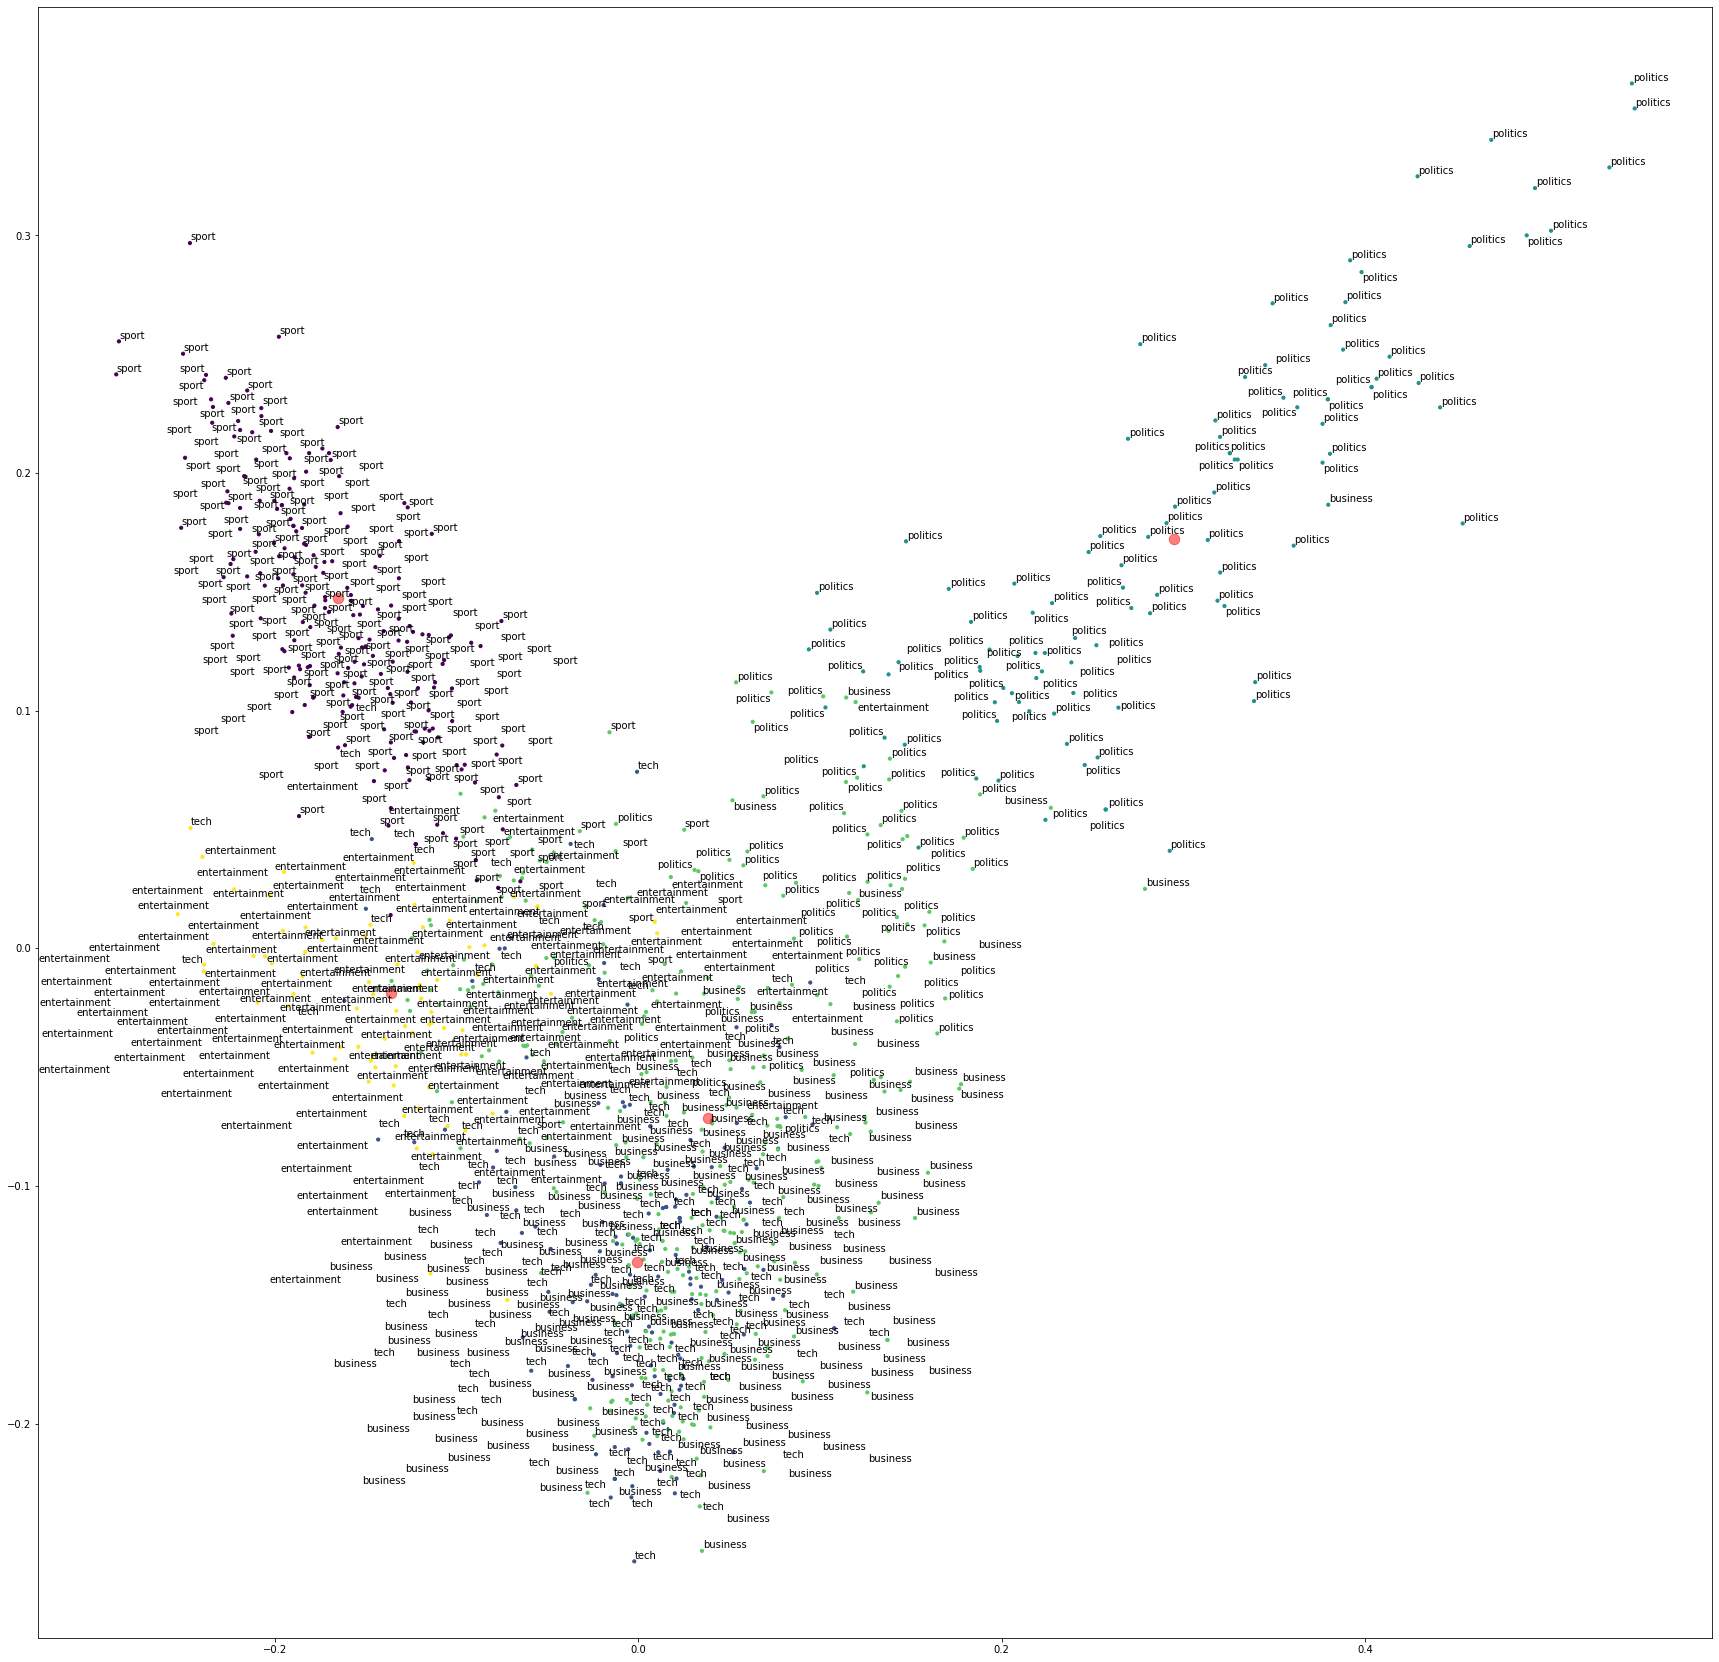

In [24]:
plot_clustering1(kmeans,tfidf_r,centroids_r,tfidf_kmeans, true_labels)

# K-means word2vec

In [25]:
kmeans = KMeans(init='k-means++',n_clusters=5,n_init=200)

w2vec_kmeans = kmeans.fit_predict(w2vec_norm)

w2vec_kmeans

array([0, 4, 2, ..., 2, 2, 1])

Visualize with <b> PCA </b>

In [26]:
pca = PCA(n_components=2)
w2vec_r = pca.fit_transform(w2vec_norm)

centroids_r = pca.transform(kmeans.cluster_centers_)

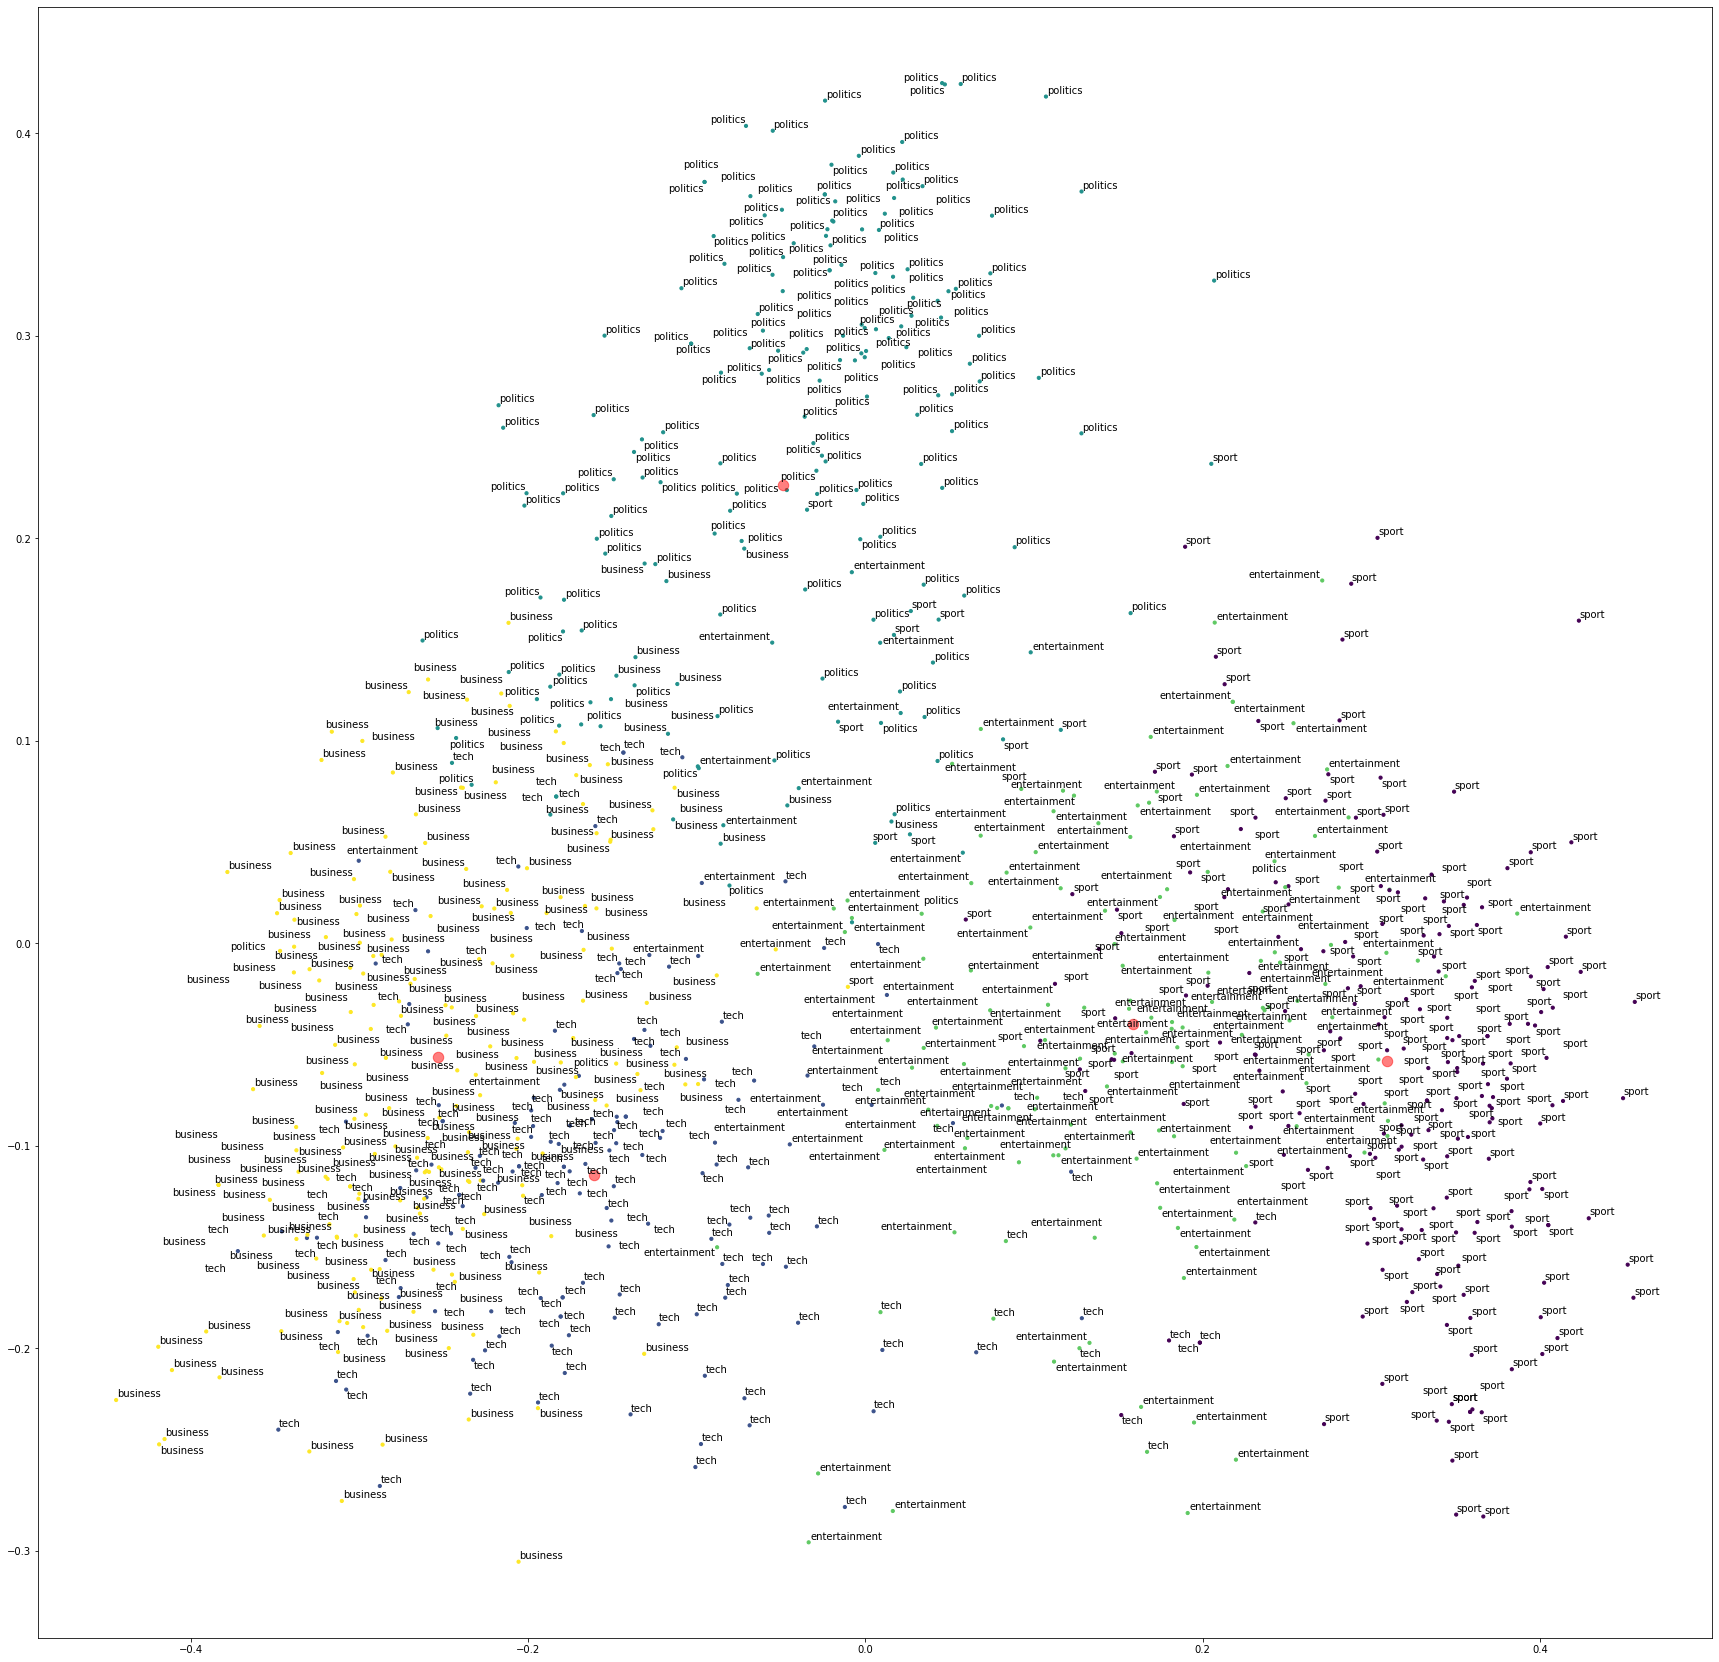

In [27]:
plot_clustering1(kmeans,w2vec_r,centroids_r,w2vec_kmeans, true_labels)